## Assignment 2 

Made by David Deng (260838166) and Edwin Meriaux (261087887)

In [1]:
!pip install gymnasium[classic-control]
!pip install gym

In [2]:
import gymnasium as gym
import numpy as np
import time
import random as rand
import matplotlib.pyplot as plt


## Section 1

In [20]:
import gym
class SARSA:
    def __init__(self,size,epsilon,explore):
        self.runs = 10
        self.segments = 500
        self.train_episodes = 10
        self.test_episodes = 1
        self.world_size = size
        self.world = np.zeros((self.world_size,self.world_size,4))
        self.world_usage = np.zeros((self.world_size,self.world_size,4))
        self.current = 0
        self.epsilon = epsilon
        self.action = 0
        
        #environment initialization
        self.env=gym.make("FrozenLake-v1", is_slippery=True)#,render_mode='human')
        self.env.reset()
        #self.env.render()
        
        #path
        self.current_path = []

        #exploration number
        self.exploration = explore
        self.decay = epsilon/explore
        self.alpha = 0.1
        self.gamma = 0.995
        self.reward = 0
        self.tmp_next = 0
        
        self.temperature = 1
        self.reward_log = np.zeros((10,500,11))
    
    def grid_pos(self,val): #turns 1D grid number into 2D [X,Y]
        x = int(val/self.world_size)
        y = val % self.world_size
        return[x,y]
    
    def max_return(self,possiblities):  #output the maxreturn action based on estimates for the action (Greedy)
        top = []
        current_return = 0
        pos = 0
        for i in possiblities:
            if i > current_return:
                top = [pos]
                current_return = i
            elif i == current_return:
                top.append(pos)
            pos += 1
        #print(top)
        if len(top) > 0:
            random_val = np.random.randint(0,len(top),1)
            return(top[random_val[0]])
        else:
            return(top[0])
    
    def max_reward_return(self,possiblities): #ouptut the reward for the max return (greedy)
        top = []
        #print("possibilities: ",possiblities)
        current_return = 0
        pos = 0
        for i in possiblities:
            if i > current_return:
                top = [pos]
                current_return = i
            elif i == current_return:
                top.append(pos)
            pos += 1
        #print(top)
        return current_return
    
   
    
    def E_greedy_action(self): #outputs greedy action (Egreedy is disabled)
        random_action = np.random.randint(0,100,2)
        if False: #random_action[0] < self.epsilon:
            action = np.random.randint(0,4,1)[0]
            #print("random: ",action)
        else:
            pos = self.grid_pos(self.current)
            #print("current position: ",pos)
            action = self.max_return(self.world[pos[0]][pos[1]])
            #print("non random: ", action)
        #print("action: ",action)
        return action
    
  
    
    def softmax(self): #gives softmax action based on current state
        pos = self.grid_pos(self.current)
        posible_action = self.world[pos[0]][pos[1]]
        probabilities = np.exp(posible_action/self.temperature)/np.sum(np.exp(posible_action/self.temperature))     
        #print("probabilities: ",probabilities)
        
        actions = [0,1,2,3]
        action = rand.choices(actions,weights=probabilities,k=1)[0]
        #print("action: ",action)
        return action
    
    def next_softmax(self): #gives next state action softmax for the next state in the Q learning algorithm
        pos = self.grid_pos(self.tmp_next)
        posible_action = self.world[pos[0]][pos[1]]
        probabilities = np.exp(posible_action/self.temperature)/np.sum(np.exp(posible_action/self.temperature))     
        actions = [0,1,2,3]
        action = rand.choices(actions,weights=probabilities,k=1)[0]
        #print("action: ",action)
        return action
    
    def next_expected_softmax(self): #expected softmax reward given state
        pos = self.grid_pos(self.tmp_next)
        posible_action = self.world[pos[0]][pos[1]]
        probabilities = np.exp(posible_action/self.temperature)/np.sum(np.exp(posible_action/self.temperature))     
        expected = np.sum(probabilities * posible_action)
        return expected
    
    def new_SARSA_reward(self): #returns reward for SARSA
        quality = 0
        #estimated reward for this step is based on the estimation from the original position
        pos = self.grid_pos(self.current)
        s_a_reward = self.world[pos[0]][pos[1]][self.action]
        next_action = self.next_softmax()
        pos = self.grid_pos(self.tmp_next)
        next_reward = self.world[pos[0]][pos[1]][next_action]
        #print("next_reward: ",next_reward)
        
        quality = s_a_reward + self.alpha*(self.reward - s_a_reward + self.gamma * next_reward)
        #print("quality update: ",quality)
        
        return quality
    
    def expected_SARSA_reward(self): #returns expected SARSA return
        quality = 0
        #estimated reward for this step is based on the estimation from the original position
        pos = self.grid_pos(self.current)
        s_a_reward = self.world[pos[0]][pos[1]][self.action]
        #next reward is based on the location arrived
        pos = self.grid_pos(self.tmp_next)
        next_reward = self.next_expected_softmax()

        
        quality = s_a_reward + self.alpha*(self.reward - s_a_reward + self.gamma * next_reward)
        #print("quality update: ",quality)
        
        return quality
    
    def loop(self):
        sucess = []
        self.reward_log = np.zeros((2,3,3,10,500,11))
        for expected in range(2):
            for temp in range(3):
                #determines the temperature of the experiment
                if temp == 0:
                    self.temperature = 0.01
                elif temp == 1:
                    self.temperature = 0.02
                elif temp == 2:
                    self.temperature = 0.03
                for learning in range(3):
                    #determines the learning rate for the experiment
                    if temp == 0:
                        self.alpha = 0.25
                    elif temp == 1:
                        self.alpha = 0.3
                    elif temp == 2:
                        self.alpha = 0.45
                    for run in range(10):
                        # Run count
                        print("run: ",run,"learnging: ",learning,"temp: ",temp,"expected: ",expected)
                        self.world = np.zeros((self.world_size,self.world_size,4))
                        self.world_usage = np.zeros((self.world_size,self.world_size,4))
                        for j in range(500):
                            #segment count
                            for i in range(10):
                                #train episdoes
                                self.current = 0
                                self.current_path = [self.current]

                                self.action = 0
                                returnValue=self.env.step(self.action)

                                #print('Initial state of the system')
                                done = False
                                self.env.reset()
                                #print("+++++++++++++++",expected,temp,learning,run,i,j,"+++++++++++")
                                steps = 0
                                while not done:
                                    steps += 1
                                    self.action = self.softmax() #greedy based action
                                    #print(self.action)

                                    returnValue=self.env.step(self.action) #take next step
                                    self.reward=returnValue[1] #get reward
                                    self.reward_log[expected][temp][learning][run][j][i] += self.reward*self.gamma**steps
                                    self.tmp_next=returnValue[0] #get position
                                    pos = self.grid_pos(self.current)
                                    if self.tmp_next != self.current:
                                        if expected == 1:
                                            self.world[pos[0]][pos[1]][self.action] = self.new_SARSA_reward() #update world reward
                                        elif expected == 0:
                                            tmp_val_val = self.expected_SARSA_reward()
                                            self.world[pos[0]][pos[1]][self.action] = tmp_val_val #update world reward
                                    self.world_usage[pos[0]][pos[1]][self.action] += 1 #update state action usage count

                                    self.current = returnValue[0] #update current location
                                    self.current_path.append(self.current) #update path taken
                                    done = returnValue[2] #update terminal check
                                reward = returnValue[1]
                                if reward > 0:
                                    sucess.append(self.current_path)
                                self.exploration -= self.decay
                                if self.exploration < 0:
                                    self.exploration = 0

                            for i in range(1):
                                #test episode
                                self.current = 0
                                self.current_path = [self.current]

                                self.action = 0
                                returnValue=self.env.step(self.action)
                                done = False
                                self.env.reset()
                                steps = 0
                                while not done:
                                    steps += 1
                                    self.action = self.E_greedy_action() #greedy based action
                                    returnValue=self.env.step(self.action) #take next step
                                    self.reward=returnValue[1] #get reward
                                    self.reward_log[expected][temp][learning][run][j][10] += self.reward*self.gamma**steps
                                    self.tmp_next=returnValue[0] #get position
                                    pos = self.grid_pos(self.current)
                                    self.current = returnValue[0] #update current location
                                    self.current_path.append(self.current) #update path taken
                                    done = returnValue[2] #update terminal check
                                reward = returnValue[1]
                                if reward > 0:
                                    sucess.append(self.current_path)
                                self.exploration -= self.decay
                                if self.exploration < 0:
                                    self.exploration = 0
                                

            #self.env.close()

In [21]:
sarsa = SARSA(4,0,200)
sarsa.loop()

run:  0 learnging:  0 temp:  0 expected:  0
run:  1 learnging:  0 temp:  0 expected:  0
run:  2 learnging:  0 temp:  0 expected:  0
run:  3 learnging:  0 temp:  0 expected:  0
run:  4 learnging:  0 temp:  0 expected:  0
run:  5 learnging:  0 temp:  0 expected:  0
run:  6 learnging:  0 temp:  0 expected:  0
run:  7 learnging:  0 temp:  0 expected:  0
run:  8 learnging:  0 temp:  0 expected:  0
run:  9 learnging:  0 temp:  0 expected:  0
run:  0 learnging:  1 temp:  0 expected:  0
run:  1 learnging:  1 temp:  0 expected:  0
run:  2 learnging:  1 temp:  0 expected:  0
run:  3 learnging:  1 temp:  0 expected:  0
run:  4 learnging:  1 temp:  0 expected:  0
run:  5 learnging:  1 temp:  0 expected:  0
run:  6 learnging:  1 temp:  0 expected:  0
run:  7 learnging:  1 temp:  0 expected:  0
run:  8 learnging:  1 temp:  0 expected:  0
run:  9 learnging:  1 temp:  0 expected:  0
run:  0 learnging:  2 temp:  0 expected:  0
run:  1 learnging:  2 temp:  0 expected:  0
run:  2 learnging:  2 temp:  0 e

The reward log stores the returns from each epsidoes runs for all the different experiments run over the course of the testing.
1. Value indicates the storage for the algorithm (SARSA or Expected SARSA).
2. Value indicates the temperature index.
3. Value indicates the learning rate index.
4. Value indicates the run index.
5. Value indicates the segment index.
6. Value indicates the episodes index (0-9 being for training and 10 being for testing)

sarsa.reward_log[expected,temp,learning,i,j,k]

In the plots for graphs set one we only use the data from the train episodes for the final segment.

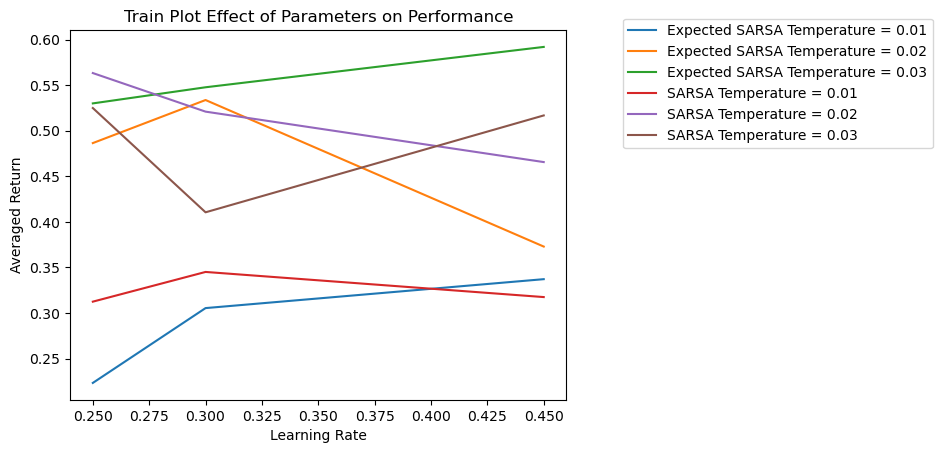

In [23]:
#taking only the required data
basic_temp0_learning0 = np.sum(sarsa.reward_log[0,0,0,:,499,0:10])/100
basic_temp0_learning1 = np.sum(sarsa.reward_log[0,0,1,:,499,0:10])/100
basic_temp0_learning2 = np.sum(sarsa.reward_log[0,0,2,:,499,0:10])/100

basic_temp1_learning0 = np.sum(sarsa.reward_log[0,1,0,:,499,0:10])/100
basic_temp1_learning1 = np.sum(sarsa.reward_log[0,1,1,:,499,0:10])/100
basic_temp1_learning2 = np.sum(sarsa.reward_log[0,1,2,:,499,0:10])/100

basic_temp2_learning0 = np.sum(sarsa.reward_log[0,2,0,:,499,0:10])/100
basic_temp2_learning1 = np.sum(sarsa.reward_log[0,2,1,:,499,0:10])/100
basic_temp2_learning2 = np.sum(sarsa.reward_log[0,2,2,:,499,0:10])/100

basic1_temp0_learning0 = np.sum(sarsa.reward_log[1,0,0,:,499,0:10])/100
basic1_temp0_learning1 = np.sum(sarsa.reward_log[1,0,1,:,499,0:10])/100
basic1_temp0_learning2 = np.sum(sarsa.reward_log[1,0,2,:,499,0:10])/100

basic1_temp1_learning0 = np.sum(sarsa.reward_log[1,1,0,:,499,0:10])/100
basic1_temp1_learning1 = np.sum(sarsa.reward_log[1,1,1,:,499,0:10])/100
basic1_temp1_learning2 = np.sum(sarsa.reward_log[1,1,2,:,499,0:10])/100

basic1_temp2_learning0 = np.sum(sarsa.reward_log[1,2,0,:,499,0:10])/100
basic1_temp2_learning1 = np.sum(sarsa.reward_log[1,2,1,:,499,0:10])/100
basic1_temp2_learning2 = np.sum(sarsa.reward_log[1,2,2,:,499,0:10])/100

learning = [0.25,0.3,0.45]
plt.plot(learning,[basic_temp0_learning0,basic_temp0_learning1,basic_temp0_learning2])

plt.plot(learning,[basic_temp1_learning0,basic_temp1_learning1,basic_temp1_learning2])

plt.plot(learning,[basic_temp2_learning0,basic_temp2_learning1,basic_temp2_learning2])

plt.plot(learning,[basic1_temp0_learning0,basic1_temp0_learning1,basic1_temp0_learning2])

plt.plot(learning,[basic1_temp1_learning0,basic1_temp1_learning1,basic1_temp1_learning2])

plt.plot(learning,[basic1_temp2_learning0,basic1_temp2_learning1,basic1_temp2_learning2])
plt.legend(["Expected SARSA Temperature = 0.01","Expected SARSA Temperature = 0.02","Expected SARSA Temperature = 0.03","SARSA Temperature = 0.01","SARSA Temperature = 0.02","SARSA Temperature = 0.03"],bbox_to_anchor=(1.1, 1.05))

plt.title("Train Plot Effect of Parameters on Performance")
plt.xlabel("Learning Rate")
plt.ylabel("Averaged Return")

plt.show()

In the plots for graphs set two we only use the data from the test episodes for the final segment.

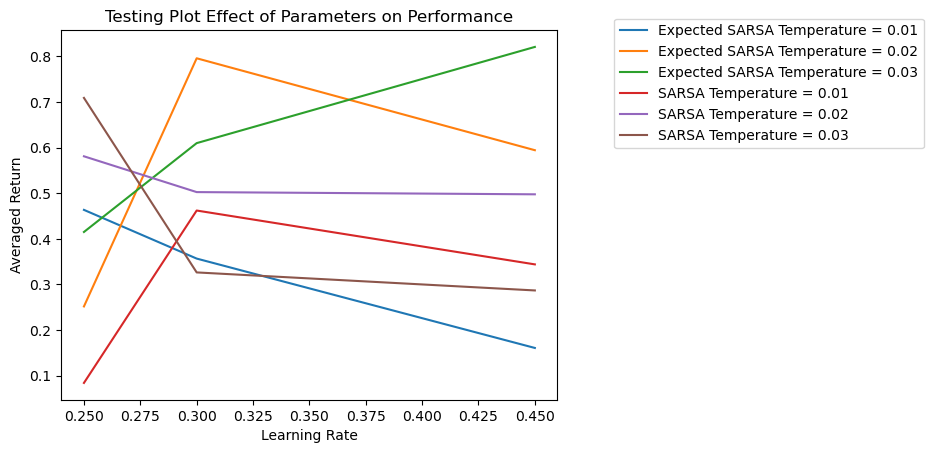

In [24]:
#taking only the required data
basic_temp0_learning0 = np.sum(sarsa.reward_log[0,0,0,:,499,10])/10
basic_temp0_learning1 = np.sum(sarsa.reward_log[0,0,1,:,490,10])/10
basic_temp0_learning2 = np.sum(sarsa.reward_log[0,0,2,:,490,10])/10

basic_temp1_learning0 = np.sum(sarsa.reward_log[0,1,0,:,499,10])/10
basic_temp1_learning1 = np.sum(sarsa.reward_log[0,1,1,:,499,10])/10
basic_temp1_learning2 = np.sum(sarsa.reward_log[0,1,2,:,499,10])/10

basic_temp2_learning0 = np.sum(sarsa.reward_log[0,2,0,:,499,10])/10
basic_temp2_learning1 = np.sum(sarsa.reward_log[0,2,1,:,499,10])/10
basic_temp2_learning2 = np.sum(sarsa.reward_log[0,2,2,:,499,10])/10

basic1_temp0_learning0 = np.sum(sarsa.reward_log[1,0,0,:,499,10])/10
basic1_temp0_learning1 = np.sum(sarsa.reward_log[1,0,1,:,499,10])/10
basic1_temp0_learning2 = np.sum(sarsa.reward_log[1,0,2,:,499,10])/10

basic1_temp1_learning0 = np.sum(sarsa.reward_log[1,1,0,:,499,10])/10
basic1_temp1_learning1 = np.sum(sarsa.reward_log[1,1,1,:,499,10])/10
basic1_temp1_learning2 = np.sum(sarsa.reward_log[1,1,2,:,499,10])/10

basic1_temp2_learning0 = np.sum(sarsa.reward_log[1,2,0,:,499,10])/10
basic1_temp2_learning1 = np.sum(sarsa.reward_log[1,2,1,:,499,10])/10
basic1_temp2_learning2 = np.sum(sarsa.reward_log[1,2,2,:,499,10])/10

learning = [0.25,0.3,0.45]
plt.plot(learning,[basic_temp0_learning0,basic_temp0_learning1,basic_temp0_learning2])

plt.plot(learning,[basic_temp1_learning0,basic_temp1_learning1,basic_temp1_learning2])

plt.plot(learning,[basic_temp2_learning0,basic_temp2_learning1,basic_temp2_learning2])

plt.plot(learning,[basic1_temp0_learning0,basic1_temp0_learning1,basic1_temp0_learning2])

plt.plot(learning,[basic1_temp1_learning0,basic1_temp1_learning1,basic1_temp1_learning2])

plt.plot(learning,[basic1_temp2_learning0,basic1_temp2_learning1,basic1_temp2_learning2])
plt.legend(["Expected SARSA Temperature = 0.01","Expected SARSA Temperature = 0.02","Expected SARSA Temperature = 0.03","SARSA Temperature = 0.01","SARSA Temperature = 0.02","SARSA Temperature = 0.03"],bbox_to_anchor=(1.1, 1.05))

plt.title("Testing Plot Effect of Parameters on Performance")
plt.xlabel("Learning Rate")
plt.ylabel("Averaged Return")
plt.show()

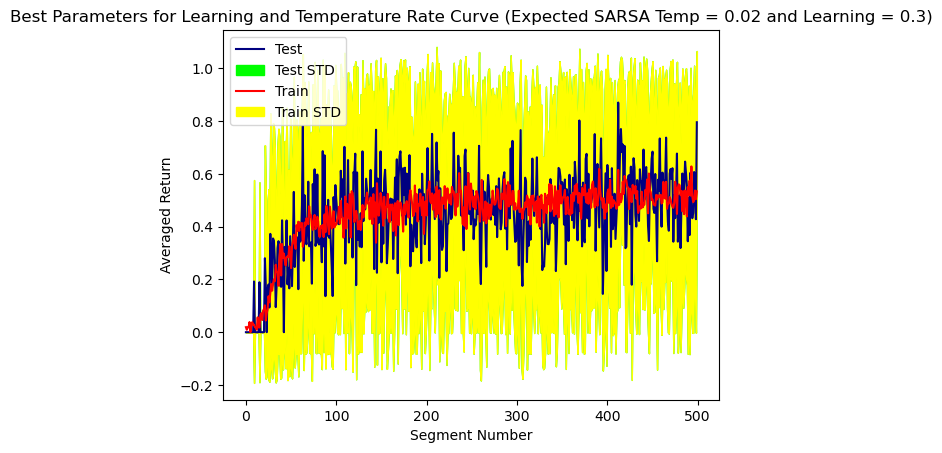

In [27]:

training_mean = np.zeros(500)
train_lower = np.zeros(500)
train_higher = np.zeros(500)

test_mean = np.zeros(500)
test_lower = np.zeros(500)
test_higher = np.zeros(500)

expected = 0
temp = 1
learning = 1

x = np.arange(0,500,1)

for j in range(500):
    std_val = np.zeros(10)
    for i in range(10):
        test_mean[j] += sarsa.reward_log[expected,temp,learning,i,j,10]/10
        std_val[i] = sarsa.reward_log[expected,temp,learning,i,j,10]
    std_cal = np.std(std_val)
    test_lower[j] = test_mean[j] - std_cal
    test_higher[j] = test_mean[j] + std_cal
    
plt.plot(x,test_mean,'navy')
#plt.ylim(-0.1, 1)
plt.fill_between(x,test_lower,test_higher,color = 'lime')
#plt.show()

for k in range(10):
    for j in range(500):
        std_val = np.zeros(10)
        for i in range(10):

            training_mean[j] += sarsa.reward_log[expected,temp,learning,i,j,k]/100
            std_val[i] = sarsa.reward_log[expected,temp,learning,i,j,k]
        std_cal = np.std(std_val)
        train_lower[j] = training_mean[j] - std_cal
        train_higher[j] = training_mean[j] + std_cal
plt.plot(x,training_mean,'red')
plt.fill_between(x,test_lower,test_higher,color = 'yellow')
#plt.ylim(-0.1, 1)
plt.legend(["Test","Test STD","Train","Train STD"])
plt.xlabel("Segment Number")
plt.ylabel("Averaged Return")
plt.title("Best Parameters for Learning and Temperature Rate Curve (Expected SARSA Temp = 0.02 and Learning = 0.3)")
plt.show()

# Report for Q1

Description of Experiments:

The code runs 2 sets of SARSA based algorithms. The first is the basic SARSA and the second is Expected SARSA. Both of them are using Softmax to determine steps while traing and using Greedy algorithm to take steps while testing. Each of the two SARSA algorithms are run with a total of 3 different learning rates and 3 temperatures. 


SARSA

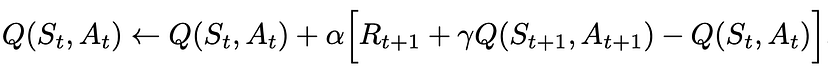

Expected SARSA

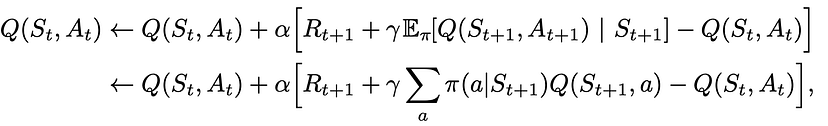

SARSA and Expected SARSA are very similar algorithms. The only difference between the two is the fact that SARSA estimates next state-action value by sampling from existing state-action estimates, while Expected sarsa uses the expectation of all possible rewards in the next states based on current policy and state-action value. This is the difference in the update portion of the SARSA equations.

In both cases the rest of the SARSA algorithm is the same. The equation modifies the Quality of the State-Action throught the addition of the learning rate times the update.

In all tests the Gamma used was 0.995. The closer the Gamma value is to 1 the lower the effect of the discount is on the system. This also increases the final return which is the:

(Final Reward) * (Gamma) ^ (Steps Taken)

The Alpha (Learning rate) was changed to see between 3 values which one was best. The chosen options were 0.25, 0.3, 0.45. These values were chosen to give a good range of values of mid sized alphas. As seen in assignment one roughly an alpha of 0.25 was optimal. In this case 0.3 was seen as best. A higher learning rate lets the system leran faster based on the most recently collected data while lower learning rate slows this down. A faster learning rate will learn faster but will be more affected by any deviation in the return.

Softmax

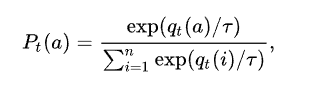

Softmax uses the expectation of reward for a given action in a state to determine which action to take next. This is used in the training phase by biasing the softmax to either be more greedy or less gred and take more random actions. This biasing is controlled by the temperature. A higher temperature causes the system to pick more random actions while a lower temperature picks the more optimal action more often. This algorithm gives effectively the probability to pick each possible actions. This probabilities must then be fed in a number generator that gives the possible actions with the necessary weights.

Rand.choices function was used to do exactly that. The possible actions [0,1,2,3] was given and same for the probabilities from the softmax.

rand.choices(actions,weights=probabilities,k=1)[0] 



This experiment was run on 3 different temperatures: 0.01, 0.02, 0.03. It was seen that a temperature of 0.02 was best.

First arrival reward update:

This code was written in two ways in terms of reward update. Based on the SARSA equation if an agent takes a step and ends up in the same spot (in this case this would be a case where the elf walks into the bounds of the space and stays in spot), that State/Action combination is still updated based on the rewards gotten (which is 0) and the estimated reward. It was seen that the algorithm works better when the agent actually does not update the estimated reward in this case. This is effectily first arrival rewards but used as a update only if the space the agent is in changes.

The number of episodes for the experiment follows the equation:

(number of SARSA algorithms) x (unique learning rates) x (unique temperatures) x (run number) x (number of segments) x (number of training + number of testing episodes)

in this case that would be equal to

2 x 3 x 3 x 10 x 500 x 11

Results

The final results show that of the tests done, the best metrics came from Expaected SARSA with Temperature of 0.02 and Learning Rate of 0.3. This was chosen from the second set of plots that showed this combination had the highest test performance on the last segment over the 10 runs. This values is a bit high, compared to the mean in plot three, due to the variation in each run (coming from the variability in the slipperiness of the ice. This is why the STD of that test (if you look at plot 3) is still high even with the high output.

The learning rate that was found as optimal was similar to that in assignment one. If the learning rate is too low the agent does not learn the environment quickly enough. But if the learning rate is too high then it is too easily affected by the last step taken. The more interesting aspect was the fact that such a low temperature worked so well. Other tests were run with higher temperatures with worse results (aside from the 3 temperatures run for the sake of this experiment). This shows how a more optimal action/greedy based Softmax works better than one based more on trying all options (an epsilon greedy with a high epsilon value).

In the test case the temperature 

# Section 2

In [ ]:
import gymnasium as gym
def get_bin_index(observation, bins, min, max):
  if (observation < min):
    return 0
  if (observation > max):
    return bins-1
  return int((observation-min)/((max-min)/bins))

In [ ]:
class Q_learning:
  def __init__(self, alpha, epsilon, gamma):
    self.weights = np.random.uniform(-0.001,0.001,(1,81))
    self.alpha=alpha
    self.epsilon=epsilon
    self.gamma=gamma
  # bin all the features into 10 bins using the ranges below
  def to_features(self, observation, action):
    features = np.zeros(81)
    features[80] = 1 # bias term
    action_padding = 0 if action == 0 else 40
    # print(observation)
    features[get_bin_index(observation[0], 10, -2.4, 2.4)+action_padding] = 1
    features[get_bin_index(observation[1], 10, -3,3)+10+action_padding] = 1
    features[get_bin_index(observation[2], 10, -0.3, 0.3)+20+action_padding] = 1
    features[get_bin_index(observation[3], 10, -3, 3)+30+action_padding] = 1

    # I attempted to refine the bin endpoints based on actual data collected, 
    # but it didn't improve performance, because the data collected depends on the agent's policy

    # print(features)

    return features
  def get_q(self, state, action):
    return np.dot(self.weights, self.to_features(state, action))
  def get_max_q(self, state):
    # print(np.dot(self.weights, self.to_features(state, 0)), np.dot(self.weights, self.to_features(state, 1)))
    return max(np.dot(self.weights, self.to_features(state, 0)), np.dot(self.weights, self.to_features(state, 1)))
  def provide_action(self, state):
    if np.random.uniform() < self.epsilon:
        action = np.random.choice(2)
    else:
        left_q = np.dot(self.weights, self.to_features(state, 0))
        right_q = np.dot(self.weights, self.to_features(state, 1))
        action = 0 if left_q > right_q else 1
    # print(action)
    return action
  def update_weights(self, reward, state, next_state, action, terminated):
    # print(self.weights)
    max_q = 0 if terminated else self.get_max_q(next_state)
    self.weights = self.weights + np.multiply(self.alpha*(reward + self.gamma*max_q - self.get_q(state, action)), self.to_features(state, action))
    return

seeds = range(50,60)
def run_q_learning(epsilon, alpha):
  print("epsilon: {}, alpha: {}".format(epsilon, alpha))
  episode_lengths_m = []
  for run in range(10):
    np.random.seed(seeds[run])
    agent = Q_learning(alpha, epsilon, 1)
    env = gym.make("CartPole-v1")
    observation, info = env.reset(seed=seeds[run])
    episode_number = 0
    timestep = 0
    observations_list = []
    episode_lengths = []
    while (episode_number < 1000):
        # collect observations into arrays
        # observations_list.append(observation)
        action = agent.provide_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        agent.update_weights(reward, observation, next_observation, action, terminated)
        observation = next_observation
        if terminated or truncated:
            episode_lengths.append(timestep+1)
            episode_number += 1
            timestep = 0
            # print("Training: Episode terminated after {} timesteps".format(timestep))
            observation, info = env.reset()
        timestep += 1
    env.close()
    # print(agent.weights)
    # print(episode_lengths)
    print("Run {} finished".format(run))
    episode_lengths_m.append(episode_lengths)
  return np.mean(episode_lengths_m, axis=0), np.std(episode_lengths_m, axis=0)
def plot_q_learning(epsilon):
  reward_per_episode_mean = []
  reward_per_episode_std = []
  for alpha in [0.25, 0.125, 0.0625]:
    mean, std = run_q_learning(epsilon, alpha)
    reward_per_episode_mean.append(mean)
    reward_per_episode_std.append(std)
  import matplotlib.pyplot as plt
  plt.figure()
  plt.errorbar(range(1000), reward_per_episode_mean[0], yerr=reward_per_episode_std[0], color='b',ecolor=(0.1, 0.2, 0.9, 0.3),label="alpha=1/4")
  plt.errorbar(range(1000), reward_per_episode_mean[1], yerr=reward_per_episode_std[1], color='m',ecolor=(0.9, 0.2, 0.1, 0.3),label="alpha=1/8")
  plt.errorbar(range(1000), reward_per_episode_mean[2], yerr=reward_per_episode_std[2], color='c',ecolor=(0.1, 0.9, 0.2, 0.3),label="alpha=1/16")
  plt.legend()
  plt.xlabel("Episode")
  plt.ylabel("Timesteps per episode")
  plt.title("Epsilon = {}".format(epsilon))
  plt.show()
  return reward_per_episode_mean, reward_per_episode_std



epsilon: 0.01, alpha: 0.25
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.01, alpha: 0.125
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.01, alpha: 0.0625
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished


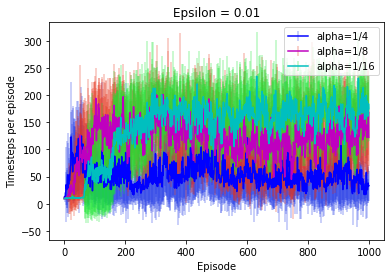

In [ ]:
mean, std = plot_q_learning(0.01)

epsilon: 0.02, alpha: 0.25
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.02, alpha: 0.125
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.02, alpha: 0.0625
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished


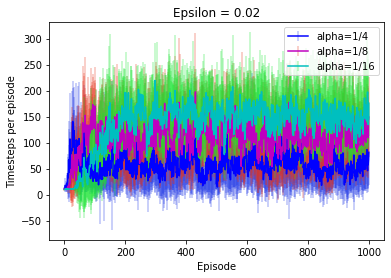

In [ ]:
_,_=plot_q_learning(0.02)

epsilon: 0.05, alpha: 0.25
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.05, alpha: 0.125
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
epsilon: 0.05, alpha: 0.0625
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished


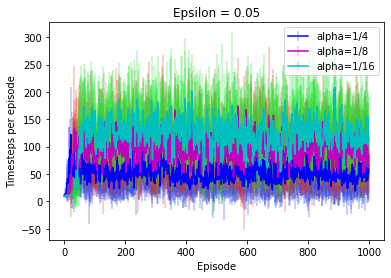

In [ ]:
_,_=plot_q_learning(0.05)

In [ ]:
class Actor_critic:
  def __init__(self, alpha, gamma):
    self.weights = np.random.uniform(-0.001,0.001,(1,41)) # state-value weights
    self.param = np.random.uniform(-0.001,0.001,(1,81)) # policy parameters
    self.alpha=alpha
    self.gamma=gamma
    self.I = 1
    # print(self.weights)
    # print(self.param)
  # bin all the features into 10 bins using the ranges below
  def to_state_value_features(self, observation):
    features = np.zeros(41)
    features[40] = 1
    # print(observation)
    features[get_bin_index(observation[0], 10, -2.4, 2.4)] = 1
    features[get_bin_index(observation[1], 10, -3,3)+10] = 1
    features[get_bin_index(observation[2], 10, -0.3, 0.3)+20] = 1
    features[get_bin_index(observation[3], 10, -3, 3)+30] = 1

    # I attempted to refine the bin endpoints based on actual data collected, 
    # but it didn't improve performance, because the data collected depends on the agent's policy

    # print(features)

    return features

  def to_policy_param_features(self, observation, action):
    features = np.zeros(81)
    features[80] = 1
    action_padding = 0 if action == 0 else 40
    # print(observation)
    features[get_bin_index(observation[0], 10, -2.4, 2.4)+action_padding] = 1
    features[get_bin_index(observation[1], 10, -3,3)+10+action_padding] = 1
    features[get_bin_index(observation[2], 10, -0.3, 0.3)+20+action_padding] = 1
    features[get_bin_index(observation[3], 10, -3, 3)+30+action_padding] = 1

    return features
  def get_q(self, state):
    return np.dot(self.weights, self.to_state_value_features(state))
  def get_pi(self, state, action, x_s_left=None, x_s_right=None, print_stuff=False):
    if (x_s_left is None):
      x_s_left = self.to_policy_param_features(state, 0)
    if (x_s_right is None):
      x_s_right = self.to_policy_param_features(state, 1)
    h_left = np.dot(self.param, x_s_left)
    h_right = np.dot(self.param, x_s_right)
    left = np.exp(h_left-max(h_left, h_right)) # prevents overflow
    right = np.exp(h_right-max(h_left, h_right))
    if (print_stuff):
      print(state)
      print(h_left, h_right)
      print(left, right)
      print(left/(left+right))
    if (action == 0):
      return left/(left+right)
    else:
      return right/(left+right)
  def provide_action(self, state, print_stuff=False):
    if (np.random.uniform() < self.get_pi(state, 0, print_stuff=print_stuff)):
      return 0
    else:
      return 1
  def update_weights(self, reward, state, next_state, action, terminated):
    # print(self.weights)
    # print(self.get_q(state))
    x_s_left = self.to_policy_param_features(state, 0)
    x_s_right = self.to_policy_param_features(state, 1)
    sum_over_actions  = np.multiply(self.get_pi(state, 0, x_s_left), x_s_left) + np.multiply(self.get_pi(state, 1, x_s_right), x_s_right)
    eligibility_vector = self.to_policy_param_features(state, action) - sum_over_actions
    v_s_w = 0 if terminated else self.get_q(next_state)
    self.param = self.param + np.multiply(self.alpha*self.I*(reward + self.gamma*v_s_w - self.get_q(state)), eligibility_vector)
    self.weights = self.weights + np.multiply(self.alpha*(reward + self.gamma*v_s_w - self.get_q(state)), self.to_state_value_features(state))

    self.I = self.I*self.gamma
    # print(self.weights)
    # print(self.param)
    return
  def new_episode(self):
    self.I = 1

In [ ]:
seeds = range(50,60)
def run_actor_critic(alpha):
  print("alpha: {}".format(alpha))
  episode_lengths_m = []
  for run in range(10):
    np.random.seed(seeds[run])
    agent = Actor_critic(alpha, 1)
    env = gym.make("CartPole-v1")
    observation, info = env.reset(seed=seeds[run])
    episode_number = 0
    timestep = 0
    observations_list = []
    episode_lengths = []
    while (episode_number < 1000):
        # collect observations into arrays
        # observations_list.append(observation)
        action = agent.provide_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        agent.update_weights(reward, observation, next_observation, action, terminated)
        observation = next_observation
        if terminated or truncated:
            episode_lengths.append(timestep+1)
            episode_number += 1
            timestep = 0
            # print("Training: Episode terminated after {} timesteps".format(timestep))
            observation, info = env.reset()
        timestep += 1
    env.close()
    # print(agent.weights)
    # print(episode_lengths)
    print("Run {} finished".format(run))
    episode_lengths_m.append(episode_lengths)
  return np.mean(episode_lengths_m, axis=0), np.std(episode_lengths_m, axis=0)
def plot_actor_critic():
  reward_per_episode_mean = []
  reward_per_episode_std = []
  for alpha in [0.25, 0.125, 0.0625]:
    mean, std = run_actor_critic(alpha)
    reward_per_episode_mean.append(mean)
    reward_per_episode_std.append(std)
  import matplotlib.pyplot as plt
  plt.figure()
  plt.errorbar(range(1000), reward_per_episode_mean[0], yerr=reward_per_episode_std[0], color='b',ecolor='y',label="alpha=1/4")
  plt.errorbar(range(1000), reward_per_episode_mean[1], yerr=reward_per_episode_std[1], color='m',ecolor='r',label="alpha=1/8")
  plt.errorbar(range(1000), reward_per_episode_mean[2], yerr=reward_per_episode_std[2], color='c',ecolor='0.8',label="alpha=1/16")
  plt.legend()
  plt.xlabel("Episode")
  plt.ylabel("Timesteps per episode")
  # plt.title("Epsilon = {}".format(epsilon))
  plt.show()
  return reward_per_episode_mean, reward_per_episode_std

alpha: 0.25
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
alpha: 0.125
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished
alpha: 0.0625
Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished
Run 5 finished
Run 6 finished
Run 7 finished
Run 8 finished
Run 9 finished


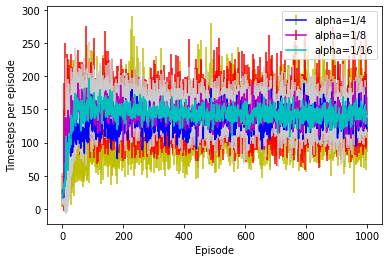

In [ ]:
actor_mean, actor_std = plot_actor_critic()

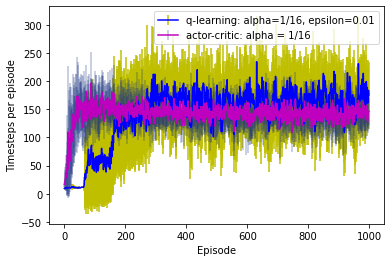

In [ ]:
plt.figure()
plt.errorbar(range(1000), mean[2], yerr=std[2], color='b',ecolor='y',label="q-learning: alpha=1/16, epsilon=0.01")
plt.errorbar(range(1000), actor_mean[2], yerr=actor_std[2], color='m',ecolor=(0.1, 0.2, 0.5, 0.3),label="actor-critic: alpha = 1/16")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Timesteps per episode")
plt.show()

## Report for Q2
In this experiment, we compare the performance of q-learning and actor-critic in cart-pole V1. 

Q-learning is a TD control algorithm that seeks to learn the value of certain state-action values. We used linear function approximation for the estimate of state values. 

In the control problem of cart-pole V1, there are four relevant variables : position of the cart, the velocity of the cart, the angle of the pole, and the angular velocity of the pole. We know from relevant literature that a complete solution to this cart-pole relies on only [the angle and angular velocities](https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f?gi=f3ed50f4af44). However, since our goal is to see how efficient different algorithms are in learning, we preserved the irrelevant variables.

We divided the variables into ten bins. For cart position and pole angle, we started by dividing the allowed (i.e. before termination) ranges into ten equal bins. We sought to improve the performance of the algorithms, and we made the pole angle bin wider. For the other two variables that have a range from -inf to inf, we arbitrarily selected a range from -3 to 3, divided the range into ten even parts, and assigned values falling out of those ranges into the end bins. Experimenting with binning schemes more can possibly create performance increase. 

We encoded the binned variables using one-hot encoding "dimension-wise". That is, we made a one-hot encoding for each dimension, so we get 4 10-dimensional one-hot encodings per state. We concatenated the encodings into a single 40-dimension vector per state.

To form the state-action encoding, we referenced Daniel Seita's "[Going Deeper Into Reinforcement Learning: Understanding Q-Learning and Linear Function Approximation](https://danieltakeshi.github.io/2016/10/31/going-deeper-into-reinforcement-learning-understanding-q-learning-and-linear-function-approximation/)", which recommended using a dimension scaling trick. We construct a length-80 vector and put the state encoding in the first half if the action is "left", and in the second half otherwise. The same source also recommended using a bias to independently scale function values with features. Even if it turns out to be unnecessary, adding a bias does not hurt our case. 

Therefore, our state-action feature vector and our weight vector have length 81, where the last term is the bias term. 

## Q-learning

The Q value of the state-action is the dot product of the weight vector and the feature vector. 

In Q-learning, state-action values are updated according to the following formula.
![Image](https://scontent.xx.fbcdn.net/v/t1.15752-9/335519250_174101685391789_1677232762606719589_n.png?_nc_cat=111&ccb=1-7&_nc_sid=aee45a&_nc_ohc=tLBBdW3Fm0gAX8Gc_Pu&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&oh=03_AdS-HKzkqfnu8LiqhXq4kbbLU2pXIO9NNffgI0UnVvMWmQ&oe=6435B849). Since we are using function approximation, modifying Q involves modifying the weight vector. The update of Q reduces to gradient descent updates of $w$ when using linear function approximation:\
$$w = w + \alpha(r + \gamma max_{a'}Q(S', a')-Q(s,a))\nabla_wQ(s,a)$$
where the gradient term at the end is just $w$, since Q is linear to $w$. 

We used epsilon-greedy to ensure sufficient exploration. We selected the epsilons by trial and error. When the epsilon is too large, the reward per episode is low, since cart-pole is not very tolerant of error caused by the randomness. We started with the standard $\epsilon=0.1$ but got much better results when we set epsilon lower. We plotted learning curves for $\epsilon=0.01, 0.02,$ and $0.05$ across 1000 episodes. Each datapoint represents the average of 10 runs. 

## Actor-critic
We implement one-step actor-critic (episodic) as outlined by Sutton et al. We parametrize the policy using a soft-max in action preferences, with linear action preferences. We parametrize the state-value function using a linear approximation.

The policy parametrization relies on using the same length-81 state-action feature vector mentioned earlier with length-81 policy parameters vector $\theta$. The preference function is just the dot product of feature vector and weights. Actor-critic also requires a state-value function, which we also construct using linear function approximation, with the weights being length-41 vector (40 to encode the state, plus one bias term).

We make use of the identity $$\nabla\pi(a|s,\theta) = x(s,a)-\sum_b\pi(b|s),\theta)x(s,b)$$ (formula 13.9 in the textbook) to compute the eligibility vector. 

## Results
As alpha decreases, it takes a larger number of episodes for the agent to learn (i.e. the learning curve rises more slowly). A high learning rate allowed the agent to learn faster at the beginning, but the asymptotic return was lower than the agent with the lower alpha. For example, in q-learning, the mean reward per episode (equalling the number of timesteps in each episode) for alpha = 0.01, 0.02, and 0.05 are appriximately 160, 125, and 50 respectively (results obtained visually from the plot). Changing epsilon has a similar effect. A lower epsilon makes the agent learn more slowly but perform accurately in the long run. This makes sense because the agent takes more time to explore but makes fewer mistakes. 

Comparing the performance of q-learning and actor-critic, we find that actor-critic converges much faster compared to q-learning and has much less variance in returns. The learning curve is less subceptible to changes in learning rate. However, it has slightly lower long-term total reward per episode (around 150) compared to the top performing q-learning agent.


In the previous experiments, the best parameter combination for q-learning is epsilon = 0.01 and alpha = 1/16. The best parameter choice for actor-critic is alpha = 1/16. 

One way to further improve performance and convergence is to allow epsilon to vary over time. The agent's learning is also contrained by the way we encode variables. Using a linear method to approximate value does not allow modelling interaction between different variables. For example, the value of a high angular velocity's depends on the angle. Using polynomials to encode features may solve this problem. 
